Import librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing
import time
import random
import torch.nn.functional as F

In [2]:
language="italian"
language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"


In [3]:
#text="question_description"
#review="ministry"
#n_top_class=35
#path_db="/kaggle/input/rajyasabha/rajyasabha_q*.{}"
#import glob
#import pandas as pd
#extension = 'csv'
#all_filenames = [i for i in glob.glob(path_db.format(extension))]
#combine all files in the list
#df = pd.concat([pd.read_csv(f,encoding='latin1') for f in all_filenames ])



In [4]:
text="testo"
review="cap_maj_master"
path_db="../input/ciao9cci/politica.xlsx"
n_top_class=35
df = pd.read_excel(path_db, sheet_name="Foglio1")

In [5]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


Import dataset

21


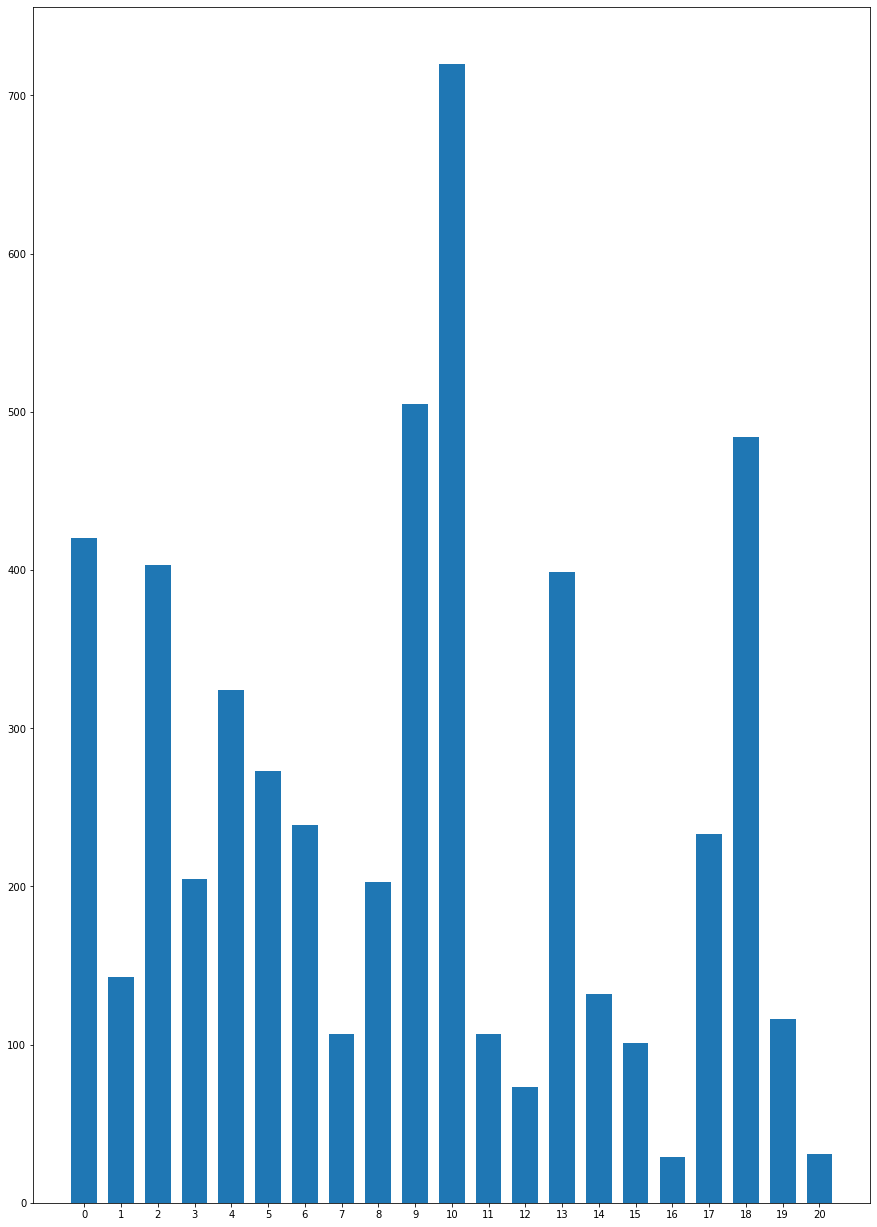

In [6]:
y = np.bincount(classes)
x = np.arange(len(y))
print(len(y))
fig, ax = plt.subplots(figsize=(15,22))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [7]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [8]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

documents, vocab = split_words_documents(documents)

In [9]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print(quant)

1375
201.02611015818562
248.0


In [10]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [11]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

In [12]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [13]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [14]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [15]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:39, 21899.03it/s]


There are 135327 / 279895 pretrained vectors found.


In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE='cpu'
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [17]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

In [18]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [19]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
import numpy as np
import torch
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [21]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.n_embed, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, n_filters)
        self.fc2 = nn.Linear(n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        

        
        
    def forward(self, text,len_text):
        
        emb = self.embedding(text)
        emb=emb.transpose(2,1)
        conved = [F.relu(c(emb)) for c in self.convs] 
        #al max_pool1d diamo come parametro il filter size
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        out=self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [22]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [23]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

In [24]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [25]:
batch_size = 128
output_dim = len(np.unique(classes))
number_of_filters = 100
filter_sizes = [1,2,3]
dropout_pc = 0.5
n_epochs = 100
nfold=10
patience=5
lr = 1e-3

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.856277  | 294.868316 |   11.25   |   3.50   
Validation loss decreased (inf --> 294.868316).  Saving model ...
   2    |  352.445633  | 280.714234 |   18.44   |   2.58   
Validation loss decreased (294.868316 --> 280.714234).  Saving model ...
   3    |  315.016394  | 242.654219 |   30.94   |   2.59   
Validation loss decreased (280.714234 --> 242.654219).  Saving model ...
   4    |  267.477855  | 208.265146 |   43.19   |   2.57   
Validation loss decreased (242.654219 --> 208.265146).  Saving model ...
   5    |  226.895804  | 185.378353 |   45.53   |   2.58   
Validation loss decreased (208.265146 --> 185.378353).  Saving model ...
   6    |  197.522427  | 172.372848 |   50.48   |   2.57   
Validation loss decreased (185.378353 --> 172.372848).  Saving model ...


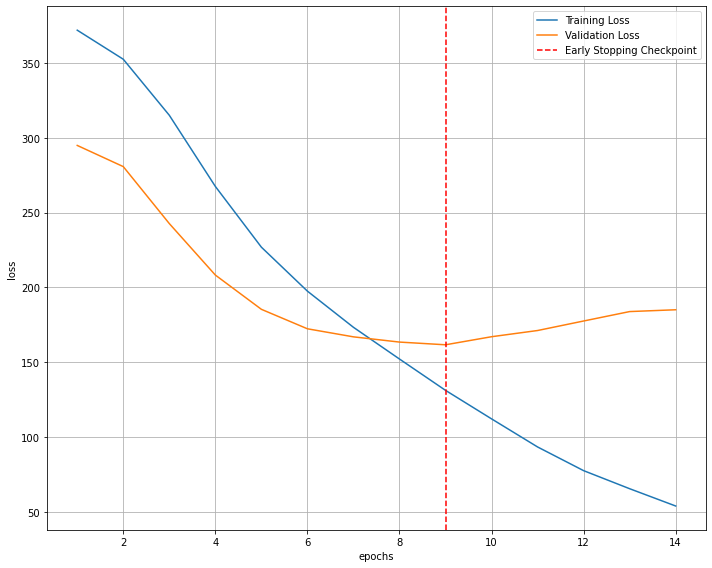

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.36      0.67      0.47        42
           1       0.29      0.13      0.18        15
           2       0.86      0.78      0.82        40
           3       0.68      0.71      0.70        21
           4       0.50      0.28      0.36        32
           5       0.79      0.96      0.87        27
           6       0.57      0.67      0.62        24
           7       0.62      0.45      0.53        11
           8       0.79      0.55      0.65        20
           9       0.72      0.82      0.77        50
          10       0.63      0.67      0.65        72
          11       0.50      0.09      0.15        11
          12       0.00      0.00      0.00         7
          13       0.35      0.33      0.34        40
          14       0.75      0.69      0.72        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

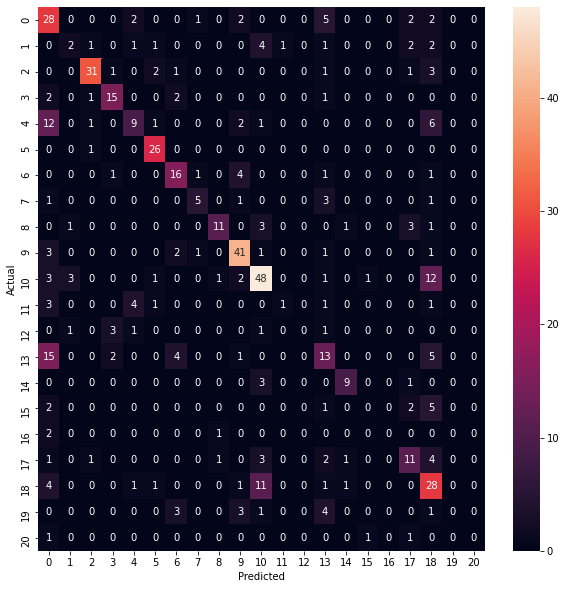


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  368.226206  | 292.978853 |   11.25   |   2.57   
Validation loss decreased (inf --> 292.978853).  Saving model ...
   2    |  348.602601  | 272.442218 |   18.12   |   2.59   
Validation loss decreased (292.978853 --> 272.442218).  Saving model ...
   3    |  305.921268  | 230.761525 |   34.38   |   2.62   
Validation loss decreased (272.442218 --> 230.761525).  Saving model ...
   4    |  256.156005  | 198.411217 |   44.59   |   2.72   
Validation loss decreased (230.761525 --> 198.411217).  Saving model ...
   5    |  215.650790  | 182.375182 |   45.71   |   2.58   
Validation loss decreased (198.411217 --> 182.375182).  Saving model ...
   6    |  188.915100  | 171.469059 |   48.05   |   2.59   
Validation loss decreased (182.375182 --> 171.469059).  Saving model ...

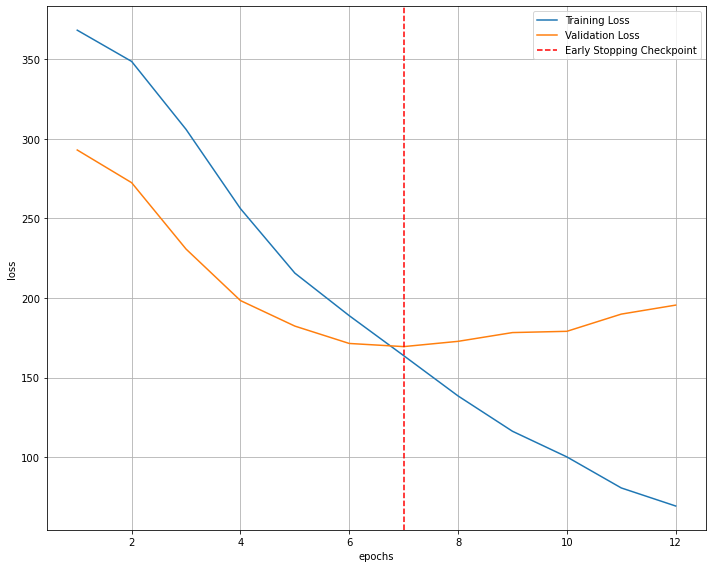

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.45      0.57      0.51        42
           1       0.29      0.13      0.18        15
           2       0.80      0.88      0.83        40
           3       0.64      0.80      0.71        20
           4       0.47      0.58      0.52        33
           5       0.84      0.75      0.79        28
           6       0.53      0.83      0.65        24
           7       0.50      0.09      0.15        11
           8       0.31      0.20      0.24        20
           9       0.72      0.88      0.79        50
          10       0.56      0.83      0.67        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.27      0.23      0.25        40
          14       0.36      0.31      0.33        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

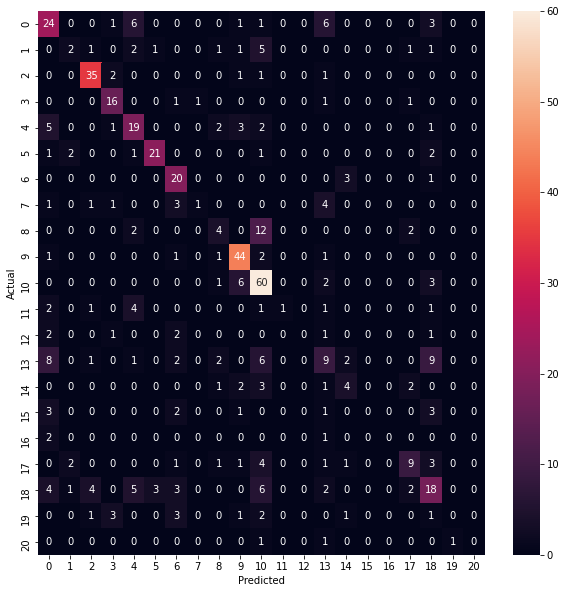


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.136534  | 293.094111 |   11.25   |   2.59   
Validation loss decreased (inf --> 293.094111).  Saving model ...
   2    |  352.419110  | 276.705046 |   13.91   |   2.57   
Validation loss decreased (293.094111 --> 276.705046).  Saving model ...
   3    |  313.221442  | 225.787535 |   34.69   |   2.57   
Validation loss decreased (276.705046 --> 225.787535).  Saving model ...
   4    |  261.516455  | 191.229440 |   47.85   |   2.56   
Validation loss decreased (225.787535 --> 191.229440).  Saving model ...
   5    |  226.384406  | 173.115068 |   49.88   |   2.57   
Validation loss decreased (191.229440 --> 173.115068).  Saving model ...
   6    |  197.844142  | 161.036782 |   53.00   |   2.58   
Validation loss decreased (173.115068 --> 161.036782).  Saving model ...

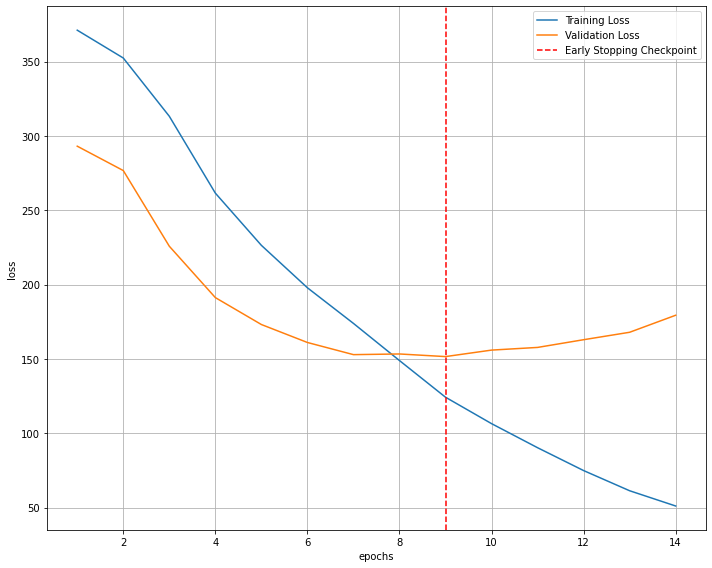

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.44      0.57      0.49        42
           1       0.75      0.21      0.33        14
           2       0.70      0.88      0.78        40
           3       0.44      0.60      0.51        20
           4       0.57      0.70      0.63        33
           5       0.78      0.89      0.83        28
           6       0.74      0.83      0.78        24
           7       0.71      0.45      0.56        11
           8       0.73      0.55      0.63        20
           9       0.80      0.80      0.80        50
          10       0.67      0.81      0.73        72
          11       0.50      0.18      0.27        11
          12       0.00      0.00      0.00         7
          13       0.38      0.38      0.38        40
          14       0.44      0.31      0.36        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

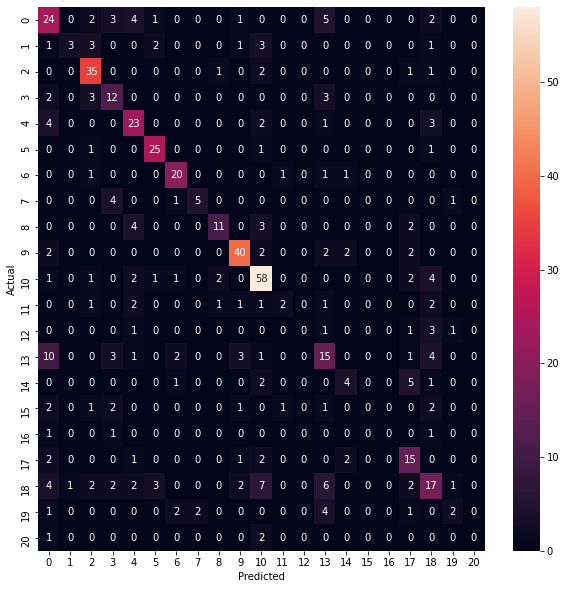


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.803955  | 293.293374 |   11.25   |   2.57   
Validation loss decreased (inf --> 293.293374).  Saving model ...
   2    |  351.914037  | 275.978399 |   18.12   |   2.59   
Validation loss decreased (293.293374 --> 275.978399).  Saving model ...
   3    |  315.239744  | 233.391266 |   33.28   |   2.58   
Validation loss decreased (275.978399 --> 233.391266).  Saving model ...
   4    |  266.799058  | 199.125460 |   43.63   |   2.58   
Validation loss decreased (233.391266 --> 199.125460).  Saving model ...
   5    |  233.218205  | 177.134784 |   48.00   |   2.57   
Validation loss decreased (199.125460 --> 177.134784).  Saving model ...
   6    |  202.486481  | 161.271257 |   52.22   |   2.59   
Validation loss decreased (177.134784 --> 161.271257).  Saving model ...

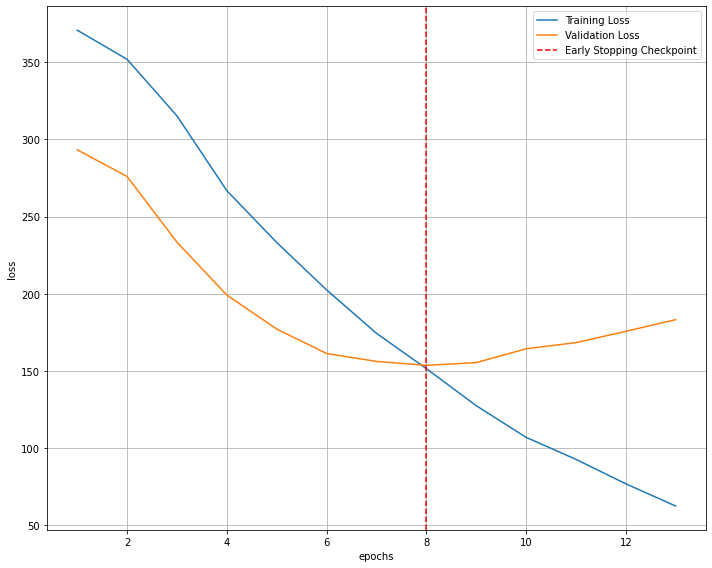

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.43      0.45      0.44        42
           1       0.75      0.21      0.33        14
           2       0.70      0.75      0.72        40
           3       0.41      0.35      0.38        20
           4       0.33      0.58      0.42        33
           5       0.70      0.93      0.80        28
           6       0.58      0.65      0.61        23
           7       0.67      0.18      0.29        11
           8       0.65      0.75      0.70        20
           9       0.78      0.86      0.82        50
          10       0.61      0.83      0.70        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.37      0.33      0.35        40
          14       0.50      0.64      0.56        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

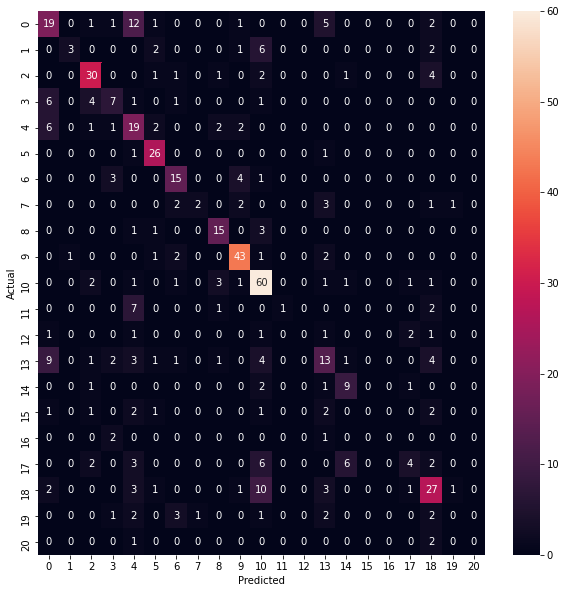


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.493733  | 292.958222 |   11.25   |   2.62   
Validation loss decreased (inf --> 292.958222).  Saving model ...
   2    |  352.643832  | 277.091671 |   17.81   |   2.57   
Validation loss decreased (292.958222 --> 277.091671).  Saving model ...
   3    |  315.743798  | 237.812383 |   33.12   |   2.58   
Validation loss decreased (277.091671 --> 237.812383).  Saving model ...
   4    |  268.046147  | 202.352166 |   41.05   |   2.58   
Validation loss decreased (237.812383 --> 202.352166).  Saving model ...
   5    |  229.124327  | 178.564812 |   48.37   |   2.61   
Validation loss decreased (202.352166 --> 178.564812).  Saving model ...
   6    |  201.902297  | 166.469222 |   52.09   |   2.57   
Validation loss decreased (178.564812 --> 166.469222).  Saving model ...

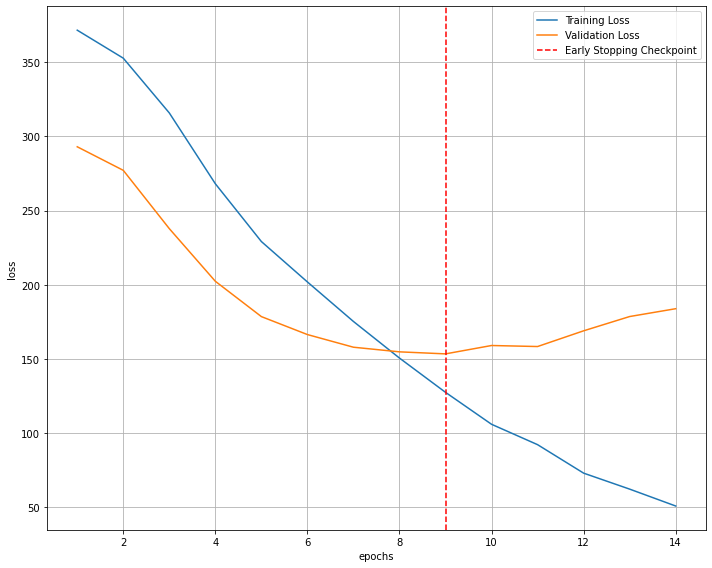

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.38      0.48      0.42        42
           1       0.20      0.07      0.11        14
           2       0.68      0.75      0.71        40
           3       0.68      0.85      0.76        20
           4       0.63      0.67      0.65        33
           5       0.64      0.78      0.70        27
           6       0.78      0.75      0.77        24
           7       0.50      0.36      0.42        11
           8       0.71      0.60      0.65        20
           9       0.70      0.82      0.76        51
          10       0.62      0.81      0.70        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.40      0.42      0.41        40
          14       0.78      0.50      0.61        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

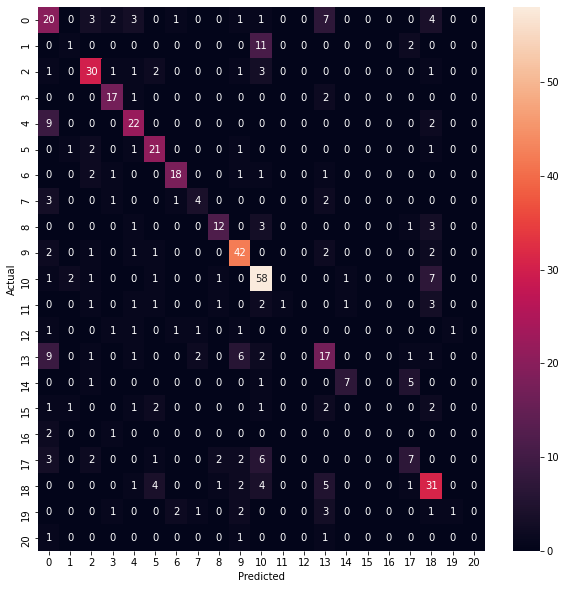


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.653242  | 293.044043 |   11.25   |   2.58   
Validation loss decreased (inf --> 293.044043).  Saving model ...
   2    |  350.912868  | 271.150771 |   21.41   |   2.57   
Validation loss decreased (293.044043 --> 271.150771).  Saving model ...
   3    |  307.534381  | 223.510497 |   34.53   |   2.59   
Validation loss decreased (271.150771 --> 223.510497).  Saving model ...
   4    |  263.286054  | 191.603975 |   47.82   |   2.58   
Validation loss decreased (223.510497 --> 191.603975).  Saving model ...
   5    |  227.074975  | 172.481896 |   55.75   |   2.58   
Validation loss decreased (191.603975 --> 172.481896).  Saving model ...
   6    |  196.993230  | 161.442830 |   57.00   |   2.60   
Validation loss decreased (172.481896 --> 161.442830).  Saving model ...

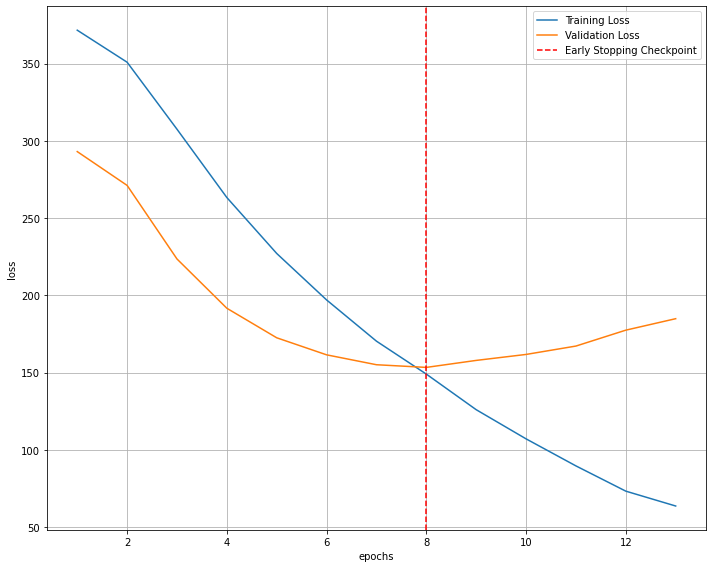

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.50      0.44        42
           1       0.33      0.14      0.20        14
           2       0.83      0.93      0.87        41
           3       0.55      0.85      0.67        20
           4       0.58      0.56      0.57        32
           5       0.74      0.93      0.82        27
           6       0.62      0.88      0.72        24
           7       1.00      0.18      0.31        11
           8       0.56      0.86      0.68        21
           9       0.67      0.84      0.75        51
          10       0.70      0.79      0.74        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.26      0.26      0.26        39
          14       0.59      0.77      0.67        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

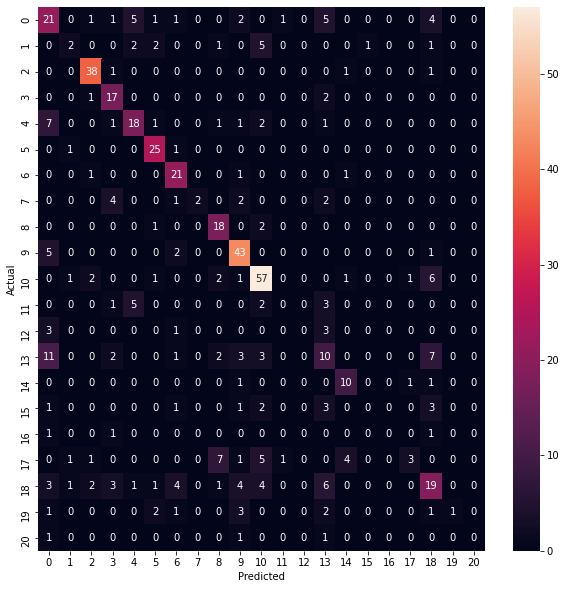


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.360030  | 292.536427 |   11.25   |   2.62   
Validation loss decreased (inf --> 292.536427).  Saving model ...
   2    |  353.915390  | 274.747708 |   18.28   |   2.58   
Validation loss decreased (292.536427 --> 274.747708).  Saving model ...
   3    |  315.438283  | 219.130588 |   34.53   |   2.57   
Validation loss decreased (274.747708 --> 219.130588).  Saving model ...
   4    |  266.496147  | 186.552050 |   41.05   |   2.58   
Validation loss decreased (219.130588 --> 186.552050).  Saving model ...
   5    |  231.939014  | 160.611456 |   51.26   |   2.59   
Validation loss decreased (186.552050 --> 160.611456).  Saving model ...
   6    |  197.915529  | 147.083041 |   55.48   |   2.57   
Validation loss decreased (160.611456 --> 147.083041).  Saving model ...

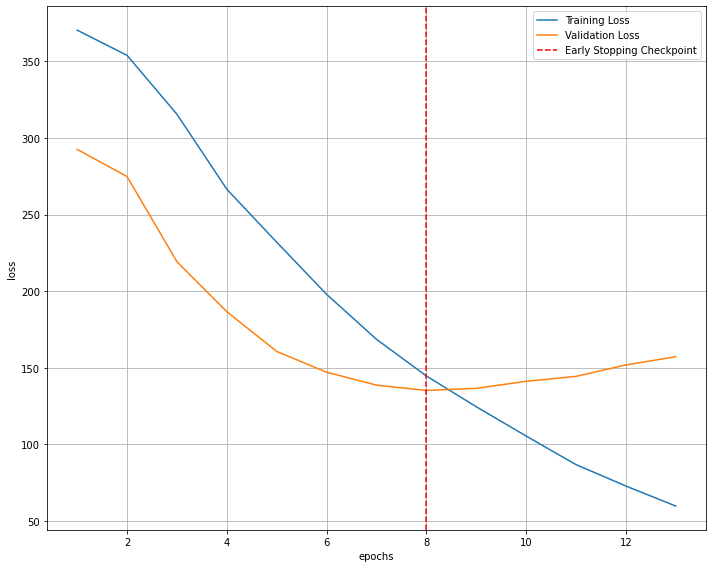

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.52      0.42        42
           1       0.25      0.07      0.11        14
           2       0.84      0.78      0.81        41
           3       0.70      0.67      0.68        21
           4       0.39      0.38      0.38        32
           5       0.71      1.00      0.83        27
           6       0.62      0.67      0.64        24
           7       0.57      0.40      0.47        10
           8       0.52      0.62      0.57        21
           9       0.83      0.88      0.86        51
          10       0.81      0.83      0.82        72
          11       0.25      0.10      0.14        10
          12       0.00      0.00      0.00         8
          13       0.46      0.53      0.49        40
          14       0.78      0.54      0.64        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

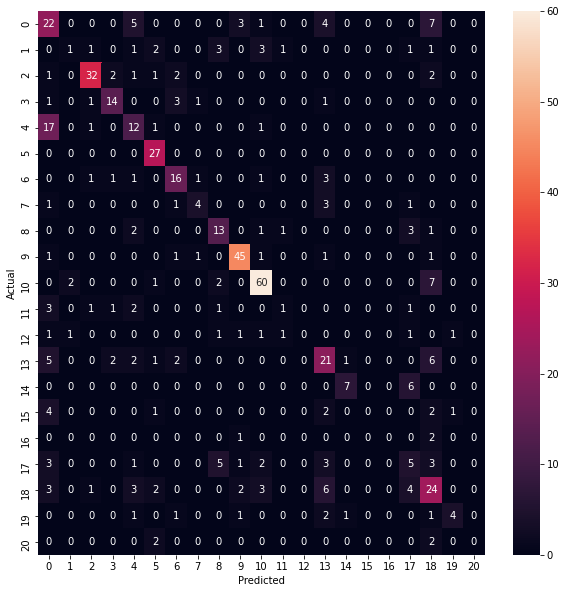


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  369.124226  | 291.197623 |   11.41   |   2.57   
Validation loss decreased (inf --> 291.197623).  Saving model ...
   2    |  348.571930  | 264.060578 |   24.53   |   2.58   
Validation loss decreased (291.197623 --> 264.060578).  Saving model ...
   3    |  305.899813  | 219.385123 |   33.28   |   2.59   
Validation loss decreased (264.060578 --> 219.385123).  Saving model ...
   4    |  261.246602  | 188.847322 |   51.88   |   2.57   
Validation loss decreased (219.385123 --> 188.847322).  Saving model ...
   5    |  221.201983  | 170.191752 |   54.17   |   2.57   
Validation loss decreased (188.847322 --> 170.191752).  Saving model ...
   6    |  190.469531  | 162.879711 |   56.04   |   2.58   
Validation loss decreased (170.191752 --> 162.879711).  Saving model ...

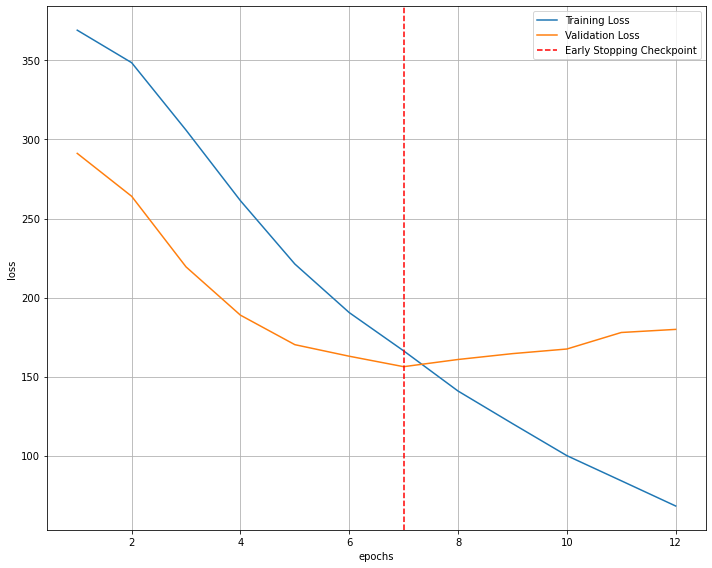

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.45      0.42        42
           1       0.00      0.00      0.00        14
           2       0.70      0.95      0.80        41
           3       0.61      0.67      0.64        21
           4       0.51      0.78      0.62        32
           5       0.79      0.85      0.82        27
           6       0.50      0.58      0.54        24
           7       1.00      0.10      0.18        10
           8       0.55      0.86      0.67        21
           9       0.78      0.75      0.76        51
          10       0.71      0.74      0.72        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.33      0.45      0.38        40
          14       0.50      0.08      0.13        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

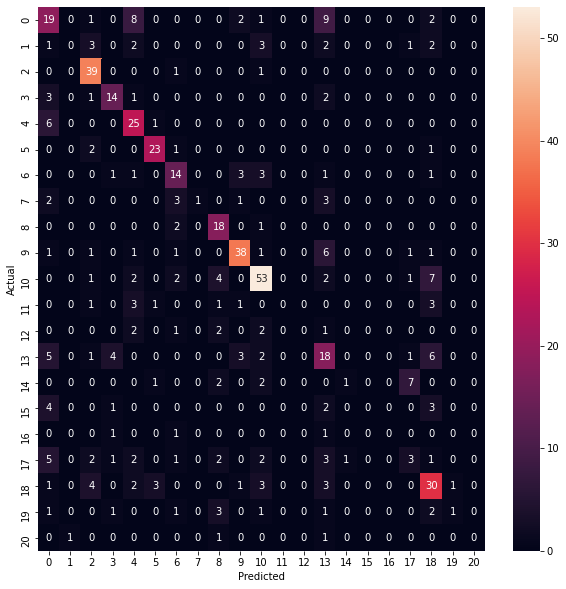


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  369.595267  | 292.623112 |   11.25   |   2.60   
Validation loss decreased (inf --> 292.623112).  Saving model ...
   2    |  352.587595  | 273.079468 |   18.59   |   2.57   
Validation loss decreased (292.623112 --> 273.079468).  Saving model ...
   3    |  311.736274  | 225.115180 |   33.12   |   2.59   
Validation loss decreased (273.079468 --> 225.115180).  Saving model ...
   4    |  264.654082  | 197.748973 |   42.03   |   2.57   
Validation loss decreased (225.115180 --> 197.748973).  Saving model ...
   5    |  232.515991  | 177.390487 |   52.92   |   2.58   
Validation loss decreased (197.748973 --> 177.390487).  Saving model ...
   6    |  200.108524  | 166.497100 |   56.93   |   2.62   
Validation loss decreased (177.390487 --> 166.497100).  Saving model ...

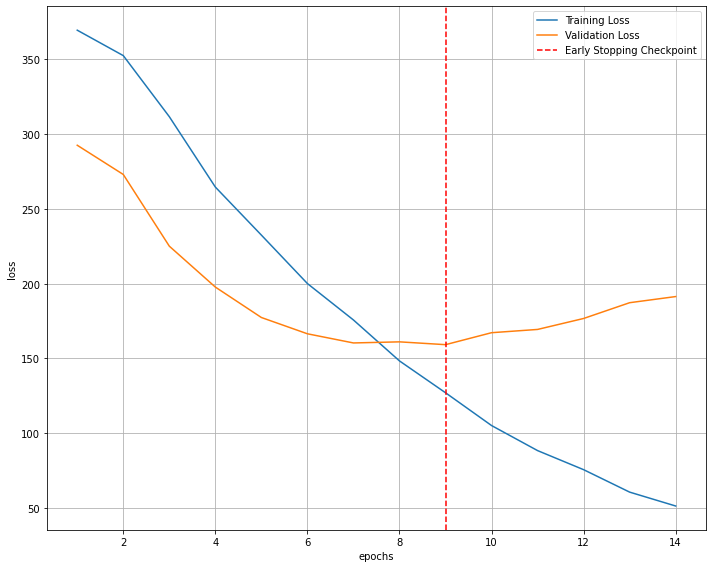

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.45      0.31      0.37        42
           1       0.38      0.21      0.27        14
           2       0.76      0.72      0.74        40
           3       0.71      0.81      0.76        21
           4       0.64      0.56      0.60        32
           5       0.52      0.81      0.64        27
           6       0.50      0.88      0.64        24
           7       0.75      0.30      0.43        10
           8       0.59      0.80      0.68        20
           9       0.73      0.78      0.75        51
          10       0.68      0.72      0.70        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.34      0.53      0.42        40
          14       0.56      0.69      0.62        13
          15       0.50      0.10      0.17        10
          16       0.00      0.00

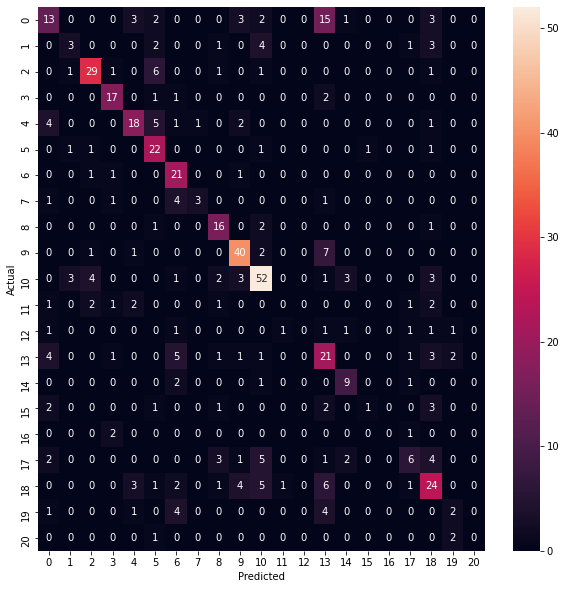


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.143379  | 292.880539 |   11.25   |   2.57   
Validation loss decreased (inf --> 292.880539).  Saving model ...
   2    |  350.610420  | 271.447166 |   19.84   |   2.58   
Validation loss decreased (292.880539 --> 271.447166).  Saving model ...
   3    |  306.377184  | 225.686117 |   36.56   |   2.58   
Validation loss decreased (271.447166 --> 225.686117).  Saving model ...
   4    |  262.437024  | 195.436721 |   44.32   |   2.57   
Validation loss decreased (225.686117 --> 195.436721).  Saving model ...
   5    |  226.320374  | 174.309665 |   50.94   |   2.58   
Validation loss decreased (195.436721 --> 174.309665).  Saving model ...
   6    |  197.667744  | 162.865243 |   56.61   |   2.57   
Validation loss decreased (174.309665 --> 162.865243).  Saving model ...

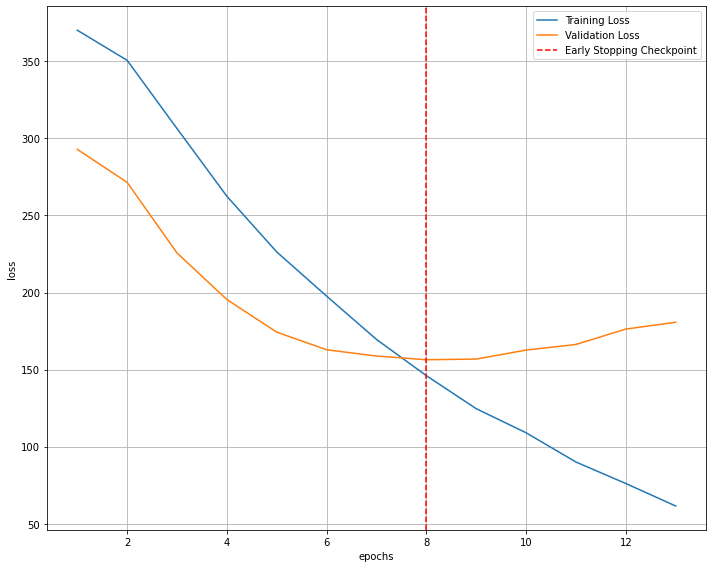

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.54      0.48      0.51        42
           1       0.17      0.07      0.10        15
           2       0.71      0.85      0.77        40
           3       0.85      0.81      0.83        21
           4       0.56      0.72      0.63        32
           5       0.57      0.93      0.70        27
           6       0.49      0.75      0.59        24
           7       0.60      0.27      0.37        11
           8       0.47      0.75      0.58        20
           9       0.73      0.86      0.79        50
          10       0.71      0.51      0.60        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.33      0.47      0.39        40
          14       0.69      0.69      0.69        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

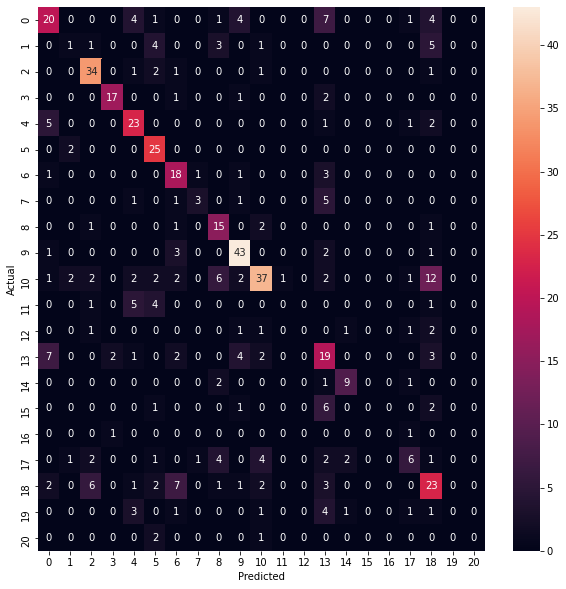

In [26]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    
    
    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=output_dim,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    model=model.double()
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


In [27]:
print("Overall results of the cross-validation procedure")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")
print()
print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

Overall results of the cross-validation procedure

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 41.90 +/- 5.25  | 50.00 +/- 8.97  | 44.89 +/- 4.27  |   42.00  
   1    | 33.96 +/-22.73  | 12.62 +/- 7.01  | 18.15 +/-10.29  |   14.30  
   2    | 75.72 +/- 6.54  | 82.59 +/- 7.59  | 78.68 +/- 4.78  |   40.30  
   3    | 62.73 +/-12.40  | 71.17 +/-14.58  | 66.24 +/-12.39  |   20.50  
   4    | 51.94 +/- 9.50  | 57.96 +/-14.59  | 53.80 +/-10.50  |   32.40  
   5    | 70.79 +/- 9.79  | 88.31 +/- 7.77  | 78.06 +/- 7.01  |   27.30  
   6    | 59.18 +/- 9.63  | 74.86 +/- 9.82  | 65.52 +/- 7.46  |   23.90  
   7    | 69.27 +/-17.19  | 28.00 +/-13.05  | 37.06 +/-12.97  |   10.70  
   8    | 58.74 +/-13.35  | 65.33 +/-18.82  | 60.33 +/-12.72  |   20.30  
   9    | 74.59 +/- 4.72  | 82.98 +/- 4.19  | 78.44 +/- 3.28  |   50.50  
  10    | 67.05 +/- 6.59  | 75.42 +/- 9.60  | 70.41 +/- 5.67  |   72.00  
  11    | 42.50 +/-41.91  | 6.45  +/- 5.87  | 10.63 +/- 9.24 